In [5]:
!pip install pandas
!pip install scikit-learn
!pip install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd

data = pd.read_csv('dataset.csv')


/var/folders/0y/351vn2xd0b1870yhsr8gwh2m0000gn/T/ipykernel_34653/590225929.py:3: DtypeWarning: Columns (0,3,5,6,7,8,9,10,11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


In [7]:
# Convert the column to datetime if it isn't already
data['track_album_release_date'] = pd.to_datetime(data['track_album_release_date'], errors='coerce')

# Convert track album to year
#data['year'] = data['track_album_release_date'].dt.year.fillna(-1).astype(int).astype(str)

# Extract just the year
data['year'] = data['track_album_release_date'].dt.year.astype('Int64')
data['year']

0        2001
1        2017
2        2005
3        2012
4        2019
         ... 
41064    <NA>
41065    <NA>
41066    <NA>
41067    <NA>
41068    <NA>
Name: year, Length: 41069, dtype: Int64

In [8]:
data = data.dropna(subset=['track_popularity'])
data.shape[0]

40721

In [9]:
from sklearn.model_selection import train_test_split # splits training from real data 
from sklearn.pipeline import Pipeline
# applies transformations to diff sub # chains processing sets
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from  sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor  # You can swap with any regressor
from sklearn.metrics import mean_squared_error


data['lyrics'] = data['lyrics'].fillna('')
# we will use these variables will predict track_popularity
numerical_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_features = 'year'
text_feature = 'lyrics'
target = 'track_popularity'
encode_artist = 'track_artist'

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")


Test MSE: 356.21


In [10]:
# Impute missing values: use KNN or similar imputation so there are no nan values
# The MSE will be higher using KNN imputer as its not meant to improve the performance
# It uses similar (nearby) rows to guess a good value instead of using nan, cleaning up the data
from sklearn.impute import KNNImputer

numerical_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),   # You can adjust n_neighbors
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

Test MSE: 356.49


In [11]:
# adding more predictor variables, using standard scaler
data['lyrics'] = data['lyrics'].fillna('')
# we will use these variables will predict track_popularity
data['song_length_minutes'] = data['duration_ms'] / 60000
data['has_lyrics'] = data['lyrics'].apply(lambda x: 0 if x.strip() == '' else 1)
current_year = 2025
data['track_age'] = current_year - data['year'].fillna(current_year).astype(int)
data['lyrics_length'] = data['lyrics'].apply(lambda x: len(x.split()))

def bucket_tempo(t):
    if t < 90:
        return 0
    elif t < 140:
        return 1
    else:
        return 2

data['tempo_bucket'] = data['tempo'].apply(bucket_tempo)

numerical_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 
                      'duration_ms', 'song_length_minutes', 'has_lyrics', 
                      'track_age', 'lyrics_length', 'tempo_bucket']
categorical_features = 'year'
text_feature = 'lyrics'
target = 'track_popularity'
encode_artist = 'track_artist'

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('text', text_pipeline, text_feature),
        ('categorical', OneHotEncoder(), [categorical_features]),
        ('artist', TargetEncoder(), [encode_artist])
    ]
)

X = data[numerical_features + [text_feature, categorical_features, encode_artist]]
y = data[target]

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))    
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")

Test MSE: 347.17


/var/folders/0y/351vn2xd0b1870yhsr8gwh2m0000gn/T/ipykernel_37441/1778346.py:12: DtypeWarning: Columns (0,3,5,6,7,8,9,10,11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("dataset.csv")


✅ best params: {'reg__max_depth': None, 'reg__learning_rate': 0.05, 'reg__l2_regularization': 1.0}
📉 MSE : 296.34
📈 R²  : 0.343


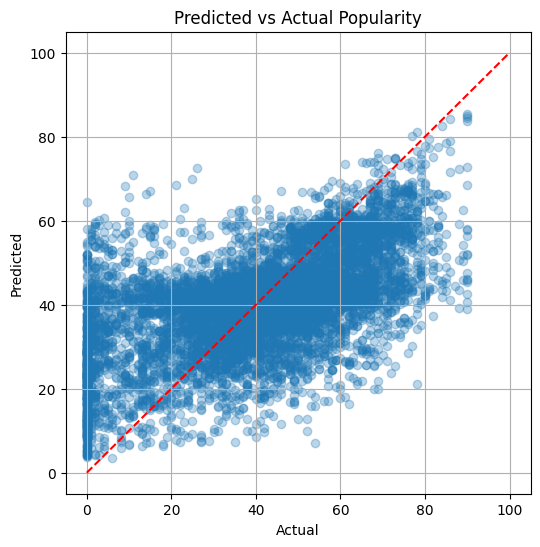

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

# 1 LOAD -------------------------------------------------------------------
data = pd.read_csv("dataset.csv")
data = data.dropna(subset=["track_popularity"])
data["lyrics"] = data["lyrics"].fillna("")

if "track_album_release_date" in data.columns:
    data["track_album_release_date"] = pd.to_datetime(
        data["track_album_release_date"], errors="coerce")
    data["year"] = data["track_album_release_date"].dt.year

# 2 FEATURES ---------------------------------------------------------------
data["song_length_minutes"] = data["duration_ms"] / 60000
data["track_age"]           = 2025 - data["year"].fillna(2025)
data["lyrics_length"]       = data["lyrics"].str.split().apply(len)
data["tempo_bucket"]        = data["tempo"].apply(lambda t: 0 if t < 90 else 1 if t < 140 else 2)
data["log_duration"]        = np.log1p(data["duration_ms"])
data["is_short_song"]       = (data["duration_ms"] < 180000).astype(int)
data["is_long_song"]        = (data["duration_ms"] > 300000).astype(int)
data["is_new_song"]         = (data["track_age"] < 2).astype(int)

# Cap extreme target values
data["track_popularity"] = np.clip(data["track_popularity"], 0, 90)

# 3 COLUMNS ---------------------------------------------------------------
num = [
    'danceability','energy','speechiness','acousticness','instrumentalness',
    'liveness','valence','tempo','duration_ms','song_length_minutes',
    'track_age','lyrics_length','log_duration'
]

cat = [
    'year','mode','playlist_genre','playlist_subgenre','tempo_bucket','key',
    'is_short_song','is_long_song','is_new_song'
]

# 👉 High-signal text-ish feature (encode to target mean)
playlist_te  = 'playlist_name' if 'playlist_name' in data.columns else None
if playlist_te:
    cat_te = [playlist_te]
else:
    cat_te = []

X = data[num + cat + cat_te]
y = data["track_popularity"]

# 4 PIPELINE ---------------------------------------------------------------
numeric_pipe = Pipeline([
    ("imp", KNNImputer(n_neighbors=5)),
    ("sc",  StandardScaler())
])

transformers = [
    ("num",  numeric_pipe, num),
    ("cat",  OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat)
]

if cat_te:
    transformers.append(
        ("plist", TargetEncoder(handle_unknown="value", handle_missing="value"), cat_te)
    )

pre = ColumnTransformer(transformers)

hgb = HistGradientBoostingRegressor(random_state=42, early_stopping=True)

pipe = Pipeline([
    ("pre", pre),
    ("reg", hgb)
])

# 5 SMALL RANDOM SEARCH (≤ 30 s) ------------------------------------------
param_dist = {
    "reg__max_depth":        [None, 5, 7],
    "reg__learning_rate":    [0.03, 0.05, 0.1],
    "reg__l2_regularization":[0.0, 0.5, 1.0]
}

search = RandomizedSearchCV(
    pipe, param_dist, n_iter=6, cv=3,
    scoring="neg_mean_squared_error", verbose=0, n_jobs=-1, random_state=42
)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
search.fit(X_tr, y_tr)

best = search.best_estimator_
y_pred = best.predict(X_te)

# 6 METRICS & PLOT ---------------------------------------------------------
mse = mean_squared_error(y_te, y_pred)
r2  = r2_score(y_te, y_pred)

print("✅ best params:", search.best_params_)
print("📉 MSE :", round(mse, 2))
print("📈 R²  :", round(r2, 3))

plt.figure(figsize=(6,6))
plt.scatter(y_te, y_pred, alpha=0.3)
plt.plot([0,100], [0,100], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Popularity")
plt.grid(True)
plt.show()
